In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

In [2]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from torch.utils.data.sampler import WeightedRandomSampler
from sklearn import preprocessing
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from src.tools.preprocess import preprocess_data
from shapely.wkt import loads


In [25]:
data = pd.read_csv('../data/processed/data.csv')
data['area'] = data["geometry"].apply(
    lambda polygon_wkt: loads(polygon_wkt).area)
data['centroid_x'] = data["geometry"].apply(
    lambda polygon_wkt: loads(polygon_wkt).centroid.x)
data['centroid_y'] = data["geometry"].apply(
    lambda polygon_wkt: loads(polygon_wkt).centroid.y)
data.head()

,Unnamed: 0,FarmID,category,Crop,State,District,Sub-District,SDate,HDate,CropCoveredArea,...,tif_path,ndvi,evi,ndwi,gndvi,savi,msavi,area,centroid_x,centroid_y
0,0,1326576,Healthy,Paddy,Telangana,Medak,Kulcharam,2023-11-25 0:00:00,2024-04-14 0:00:00,97,...,downloads/20240412T050649_20240412T051727_T43Q...,0.100756,-0.793684,8.488031,0.127153,0.151125,4232.596191,9.956528e-07,78.181592,17.978863
1,1,1326577,Healthy,Paddy,Telangana,Medak,Kulcharam,2023-11-13 0:00:00,2024-04-26 0:00:00,82,...,downloads/20240425T051649_20240425T052817_T43Q...,0.188090,0.564248,11.493762,0.187815,0.282110,3249.392822,1.497475e-06,78.175606,17.980966
2,2,1326578,Healthy,Paddy,Telangana,Medak,Kulcharam,2023-12-19 0:00:00,2024-04-28 0:00:00,92,...,downloads/20240427T050651_20240427T051439_T43Q...,0.206596,-1.456745,10.166884,0.206553,0.309869,3741.956055,9.668150e-07,78.169207,17.976084
3,3,1331836,Diseased,Paddy,Telangana,Medak,Kulcharam,2023-02-11 0:00:00,2024-11-04 0:00:00,91,...,downloads/20241103T050951_20241103T052004_T43Q...,0.206250,2.206184,10.446196,0.220995,0.309350,3673.396729,1.186327e-06,78.169059,17.974588
4,4,1326579,Diseased,Paddy,Telangana,Medak,Kulcharam,2023-12-12 0:00:00,2024-05-19 0:00:00,94,...,downloads/20240517T050651_20240517T051655_T43Q...,0.179721,-0.743638,8.665929,0.160657,0.269563,4227.338379,5.810344e-07,78.172695,17.969159


In [26]:
data = data[data["dataset"] == "train"]
data['date'] = pd.to_datetime(data['SDate'])
data = data.sort_values(by='SDate')
data_clean, anomalies = preprocess_data(data)

In [50]:
feature_columns = [
    'CropCoveredArea',  'IrriCount', 'WaterCov', 'ExpYield',
    'ndvi',  'ndwi', 'gndvi', 'savi', 'msavi', 'SDate_year', 'SDate_month',
    'SDate_day', 'HDate_year',  'centroid_y', 'centroid_x', 'area' , #'CHeight','HDate_month', 'HDate_day','evi',
]
X = data_clean[feature_columns]
X = np.array(X)
y = data_clean['category']
enc = preprocessing.OneHotEncoder()
le = LabelEncoder()
y = le.fit_transform(y)
for i in range(4):
    print(f"classe {i} : {(y == i).sum()/y.sum():2.2%}")
le.classes_

classe 0 : 5.42%
classe 1 : 74.40%
classe 2 : 5.55%
classe 3 : 4.84%


array(['Diseased', 'Healthy', 'Pests', 'Stressed'], dtype=object)

In [51]:


# Calcul de la corrélation entre chaque colonne de la matrice et le vecteur
correlations = np.corrcoef(X, rowvar=False, bias=True)

# Extraire les corrélations entre les colonnes de la matrice et le vecteur
corr_vecteur = [np.corrcoef(X[:, i], y)[0, 1] for i in range(X.shape[1])]
for i, col in enumerate(feature_columns):
    print(f"{col} : {corr_vecteur[i]:2.2f}")

CropCoveredArea : -0.06
IrriCount : -0.04
WaterCov : -0.06
ExpYield : -0.02
ndvi : 0.02
ndwi : 0.02
gndvi : 0.01
savi : 0.02
msavi : -0.02
SDate_year : 0.01
SDate_month : -0.02
SDate_day : -0.02
HDate_year : -0.02
centroid_y : 0.05
centroid_x : -0.02
area : 0.03


/tmp/ipykernel_137896/2598481996.py:2: DeprecationWarning: bias and ddof have no effect and are deprecated
  correlations = np.corrcoef(X, rowvar=False, bias=True)


In [52]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.05, random_state=42)

In [46]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN


# Print the original class distribution
print("Original class distribution:", np.bincount(y))

# Apply ADASYN
adasyn = ADASYN(sampling_strategy='minority', random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

# Print the new class distribution
print("Resampled class distribution:", np.bincount(y_resampled))




""" smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
print("Shape of X_resampled:", X_resampled.shape)
print("Shape of y_resampled:", y_resampled.shape)
print("Unique classes after resampling:", np.unique(y_resampled))
print("Data type of y_resampled:", y_resampled.dtype)

for i in np.unique(y_resampled):
    proportion = (y_resampled == i).sum() / y_resampled.shape[0]
    print(f"Classe {i} : {proportion:.2%}") """

Original class distribution: [ 474 6506  485  423]
Resampled class distribution: [ 474 6506  485 6378]


' smote = SMOTE(random_state=42)\nX_resampled, y_resampled = smote.fit_resample(X_train, y_train)\nprint("Shape of X_resampled:", X_resampled.shape)\nprint("Shape of y_resampled:", y_resampled.shape)\nprint("Unique classes after resampling:", np.unique(y_resampled))\nprint("Data type of y_resampled:", y_resampled.dtype)\n\nfor i in np.unique(y_resampled):\n    proportion = (y_resampled == i).sum() / y_resampled.shape[0]\n    print(f"Classe {i} : {proportion:.2%}") '

In [53]:
#X_train, y_train = X_resampled, y_resampled
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [54]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, sequence_length):
        self.sequence_length = sequence_length
        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(X)

        # Création des séquences
        self.sequences = []
        self.labels = []
        for i in range(len(X) - sequence_length + 1):
            sequence = X_scaled[i:(i + sequence_length)]
            self.sequences.append(sequence)
            self.labels.append(y[i + sequence_length - 1])

        self.sequences = torch.FloatTensor(np.array(self.sequences))
        self.labels = torch.LongTensor(np.array(self.labels))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]


class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes, dropout=0.3):
        super(LSTMClassifier, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )

        self.batch_norm = nn.BatchNorm1d(hidden_dim * 2)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]

        out = self.batch_norm(lstm_out)
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = nn.Softmax(dim=1)(out)

        return out


class LSTMTrainer:
    def __init__(self, input_dim, hidden_dim=128, num_layers=2, num_classes=4,
                 sequence_length=10, learning_rate=0.001):
        self.device = torch.device(
            'cuda' if torch.cuda.is_available() else 'cpu')
        self.model = LSTMClassifier(
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            num_layers=num_layers,
            num_classes=num_classes
        ).to(self.device)

        self.sequence_length = sequence_length
        self.num_classes = num_classes
        self.learning_rate = learning_rate

    def calculate_class_weights(self, y):
        # Calcul des poids des classes
        class_counts = Counter(y)
        total_samples = len(y)

        # Initialisation des poids pour toutes les classes
        weights = np.zeros(self.num_classes)

        # Calcul des poids pour chaque classe
        for i in range(self.num_classes):
            # Si la classe est présente, calculer son poids
            # Sinon, utiliser un poids par défaut
            if i in class_counts:
                weights[i] = total_samples / \
                    (len(class_counts) * class_counts[i])
            else:
                # Poids par défaut pour les classes non présentes
                weights[i] = 1.0

        return torch.FloatTensor(weights).to(self.device)

    def create_sampler(self, y):
        # Création d'un sampler pondéré pour équilibrer les classes
        class_counts = Counter(y)
        weights = [1.0 / class_counts[label] for label in y]
        weights = torch.DoubleTensor(weights)
        sampler = WeightedRandomSampler(weights, len(weights))
        return sampler

    def train(self, X, y, batch_size=32, epochs=100, validation_split=0.2):
        dataset = TimeSeriesDataset(X, y, self.sequence_length)

        # Séparation train/val avant le sampling
        train_size = int((1 - validation_split) * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = torch.utils.data.random_split(
            dataset, [train_size, val_size]
        )


        train_labels = [dataset.labels[i] for i in train_dataset.indices]

        train_sampler = self.create_sampler(train_labels)

        class_weights = self.calculate_class_weights(train_labels)


        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            sampler=train_sampler
        )
        val_loader = DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False
        )

        # Initialisation du critère avec les poids des classes
        self.criterion = nn.CrossEntropyLoss(weight=class_weights)
        self.optimizer = optim.Adam(
            self.model.parameters(),
            lr=self.learning_rate,
            weight_decay=1e-5
        )

        best_val_loss = float('inf')
        patience = 10
        patience_counter = 0

        for epoch in range(epochs):
            # Mode entraînement
            self.model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0
            train_class_correct = [0] * self.num_classes
            train_class_total = [0] * self.num_classes

            for sequences, labels in train_loader:
                sequences, labels = sequences.to(
                    self.device), labels.to(self.device)

                self.optimizer.zero_grad()
                outputs = self.model(sequences)
                loss = self.criterion(outputs, labels)

                loss.backward()
                torch.nn.utils.clip_grad_norm_(
                    self.model.parameters(), max_norm=1.0)
                self.optimizer.step()

                train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()

                # Calcul des métriques par classe
                for i in range(self.num_classes):
                    mask = labels == i
                    train_class_correct[i] += (predicted[mask]
                                               == i).sum().item()
                    train_class_total[i] += mask.sum().item()

            # Mode validation
            self.model.eval()
            val_loss = 0
            val_correct = 0
            val_total = 0
            val_class_correct = [0] * self.num_classes
            val_class_total = [0] * self.num_classes

            with torch.no_grad():
                for sequences, labels in val_loader:
                    sequences, labels = sequences.to(
                        self.device), labels.to(self.device)
                    outputs = self.model(sequences)
                    loss = self.criterion(outputs, labels)

                    val_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()

                    # Calcul des métriques par classe
                    for i in range(self.num_classes):
                        mask = labels == i
                        val_class_correct[i] += (predicted[mask]
                                                 == i).sum().item()
                        val_class_total[i] += mask.sum().item()

            # Calcul et affichage des métriques
            train_loss = train_loss / len(train_loader)
            train_acc = 100 * train_correct / train_total
            val_loss = val_loss / len(val_loader)
            val_acc = 100 * val_correct / val_total

            print(f'\nEpoch [{epoch+1}/{epochs}]')
            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

            print("\nPrécision par classe (Train):")
            for i in range(self.num_classes):
                acc = 100 * \
                    train_class_correct[i] / \
                    train_class_total[i] if train_class_total[i] > 0 else 0
                print(f'Classe {i}: {acc:.2f}% ({
                      train_class_total[i]} échantillons)')

            print("\nPrécision par classe (Validation):")
            for i in range(self.num_classes):
                acc = 100 * \
                    val_class_correct[i] / \
                    val_class_total[i] if val_class_total[i] > 0 else 0
                print(f'Classe {i}: {acc:.2f}% ({
                      val_class_total[i]} échantillons)')

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                torch.save(self.model.state_dict(), 'best_model.pth')
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Early stopping triggered")
                    break

    def predict(self, X):
        dataset = TimeSeriesDataset(X, np.zeros(len(X)), self.sequence_length)
        loader = DataLoader(dataset, batch_size=32, shuffle=False)

        self.model.eval()
        predictions = []

        with torch.no_grad():
            for sequences, _ in loader:
                sequences = sequences.to(self.device)
                outputs = self.model(sequences)
                _, predicted = torch.max(outputs.data, 1)
                predictions.extend(predicted.cpu().numpy())

        return np.array(predictions)

    def evaluate(self, X, y):
        predictions = self.predict(X)
        y_true = y[self.sequence_length-1:]

        print("Classification Report:")
        print(classification_report(y_true, predictions))

        print("\nConfusion Matrix:")
        print(confusion_matrix(y_true, predictions))


Epoch [1/5]
Train Loss: 0.9292, Train Acc: 81.48%
Val Loss: 0.9095, Val Acc: 83.36%

Précision par classe (Train):
Classe 0: 0.00% (331 échantillons)
Classe 1: 99.72% (4283 échantillons)
Classe 2: 0.00% (347 échantillons)
Classe 3: 0.00% (281 échantillons)

Précision par classe (Validation):
Classe 0: 0.00% (129 échantillons)
Classe 1: 100.00% (1873 échantillons)
Classe 2: 0.00% (119 échantillons)
Classe 3: 0.00% (126 échantillons)

Epoch [2/5]
Train Loss: 0.9228, Train Acc: 82.07%
Val Loss: 0.9095, Val Acc: 83.36%

Précision par classe (Train):
Classe 0: 0.00% (303 échantillons)
Classe 1: 100.00% (4302 échantillons)
Classe 2: 0.00% (353 échantillons)
Classe 3: 0.00% (284 échantillons)

Précision par classe (Validation):
Classe 0: 0.00% (129 échantillons)
Classe 1: 100.00% (1873 échantillons)
Classe 2: 0.00% (119 échantillons)
Classe 3: 0.00% (126 échantillons)

Epoch [3/5]
Train Loss: 0.9244, Train Acc: 81.93%
Val Loss: 0.9095, Val Acc: 83.36%

Précision par classe (Train):
Classe 0:

/home/paul/.cache/pypoetry/virtualenvs/telangana-crop-health-challenge-Bgz_xKMH-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/paul/.cache/pypoetry/virtualenvs/telangana-crop-health-challenge-Bgz_xKMH-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/paul/.cache/pypoetry/virtualenvs/telangana-crop-health-challenge-Bgz_xKMH-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and bein

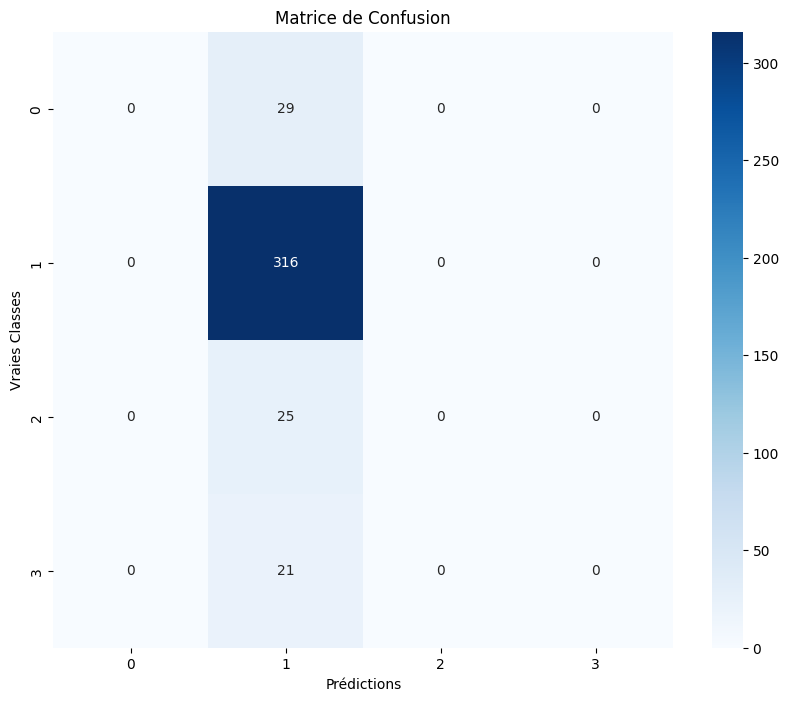

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
trainer = LSTMTrainer(
    input_dim=X_train.shape[1],
    hidden_dim=128,
    num_layers=2,
    num_classes=4,
    sequence_length=5,
    learning_rate=0.01
)
trainer.train(
    X_train,
    y_train,
    batch_size=16,
    epochs=5,  
    validation_split=0.3
)

predictions = trainer.predict(X_test)


trainer.evaluate(X_test, y_test)


def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true[4:], y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Matrice de Confusion')
    plt.ylabel('Vraies Classes')
    plt.xlabel('Prédictions')
    plt.show()


print(y_test.shape, predictions.shape)
plot_confusion_matrix(y_test, predictions)

In [19]:
print(y_test.shape, predictions.shape)
print("Rapport de classification :\n",
      classification_report(y_test[9:], predictions))

(395,) (386,)
Rapport de classification :
               precision    recall  f1-score   support

           0       0.08      0.52      0.14        29
           1       0.00      0.00      0.00       312
           2       0.07      0.58      0.12        24
           3       0.00      0.00      0.00        21

    accuracy                           0.08       386
   macro avg       0.04      0.28      0.07       386
weighted avg       0.01      0.08      0.02       386



/home/paul/.cache/pypoetry/virtualenvs/telangana-crop-health-challenge-Bgz_xKMH-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/paul/.cache/pypoetry/virtualenvs/telangana-crop-health-challenge-Bgz_xKMH-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/paul/.cache/pypoetry/virtualenvs/telangana-crop-health-challenge-Bgz_xKMH-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and bein

In [35]:
def apply_geometry(data):
    data['area'] = data["geometry"].apply(
    lambda polygon_wkt: loads(polygon_wkt).area)
    data['centroid_x'] = data["geometry"].apply(
        lambda polygon_wkt: loads(polygon_wkt).centroid.x)
    data['centroid_y'] = data["geometry"].apply(
        lambda polygon_wkt: loads(polygon_wkt).centroid.y)
    data.head()
    return data

In [36]:
test_encoded = pd.read_csv("../data/processed/data.csv")

test_encoded = test_encoded[test_encoded["dataset"]=="test"]
test_encoded['FarmID'] = test_encoded["FarmID"].astype(str)
test_encoded.drop(columns=["category"], inplace=True)
test_encoded, anomalies = preprocess_data(test_encoded)
test_encoded  = apply_geometry(test_encoded)
test_encoded = pd.concat([data_clean.iloc[0:9], test_encoded], ignore_index=True)
test_encoded.drop(columns=["category"], inplace=True)
feature_columns = [
    'CropCoveredArea', 'CHeight', 'IrriCount', 'WaterCov', 'ExpYield',
    'ndvi', 'evi', 'ndwi', 'gndvi', 'savi', 'msavi', 'SDate_year', 'SDate_month',
       'SDate_day', 'HDate_year', 'HDate_month', 'HDate_day','centroid_y', 'centroid_x','area'
]
4
X_test_submission =test_encoded[feature_columns]
X_test_submission = scaler.transform(X_test_submission)




test_predictions = trainer.predict(X_test_submission)
print(test_predictions.shape)
test_predictions_decoded = le.inverse_transform(test_predictions)

sample_submission = pd.DataFrame()
sample_submission['ID'] = test_encoded["FarmID"].astype(str)[9:]  # Convertir en chaîne de caractères
sample_submission['Target'] = test_predictions_decoded

# Aperçu du DataFrame
sample_submission.head()

# Sauvegarder le fichier de soumission
sample_submission.to_csv('submission_2.csv', index=False)

/home/paul/code/python/zindi/AAIS-AI/zindi_telangana_crop_health_challenge/src/tools/preprocess.py:58: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9246.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_clean.loc[non_null_mask & outlier_mask, col] = clean_mean
/home/paul/code/python/zindi/AAIS-AI/zindi_telangana_crop_health_challenge/src/tools/preprocess.py:58: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '77.80242825607064' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_clean.loc[non_null_mask & outlier_mask, col] = clean_mean
/home/paul/code/python/zindi/AAIS-AI/zindi_telangana_crop_health_challenge/src/tools/preprocess.py:58: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future ver

(2718,)
